<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Pytorch_Workout_Convolutional_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CIFAR10 Classification**

In [1]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import torch as t
import torchvision as tv
import PIL as pil
import requests as req
import matplotlib.pyplot as plt

**Loading Data**

In [3]:
transform_train = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness = .2, contrast = .2, saturation = .2, hue = .2),
    tv.transforms.RandomAffine(degrees = 20, translate = (.2, .2), scale = (.8, 1.2), shear = 10),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor()
])
transform_valid = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

dataset_train = tv.datasets.CIFAR10('.', train = True, download = True, transform = transform_train)
dataset_valid = tv.datasets.CIFAR10('.', train = False, download = True, transform = transform_valid)

loader_train = t.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle = True)
loader_valid = t.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle = False)

0it [00:00, ?it/s]

170500096it [00:06, 25325264.95it/s]                               


Files already downloaded and verified


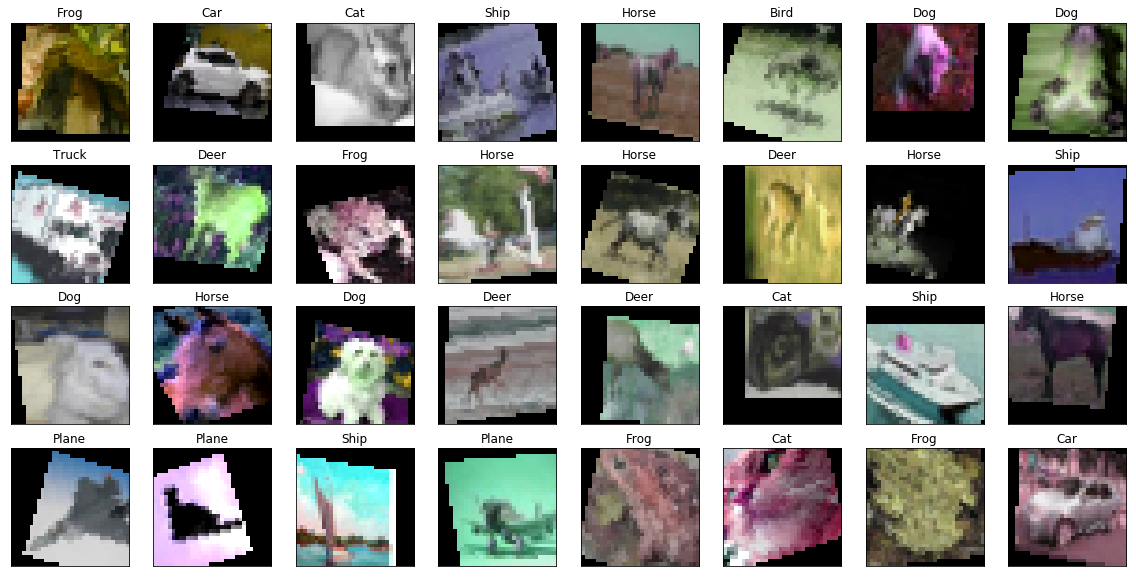

In [4]:
CIFAR_classes = 'Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'

imgs, labels = next(iter(loader_train))

def plot_img(img, label):
  img = img.numpy()
  img = img.transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(CIFAR_classes[label])

fig = plt.figure(figsize = (20, 10))

for i in range(32):
  fig.add_subplot(4, 8, i + 1, xticks = [], yticks = [])
  plot_img(imgs[i], labels[i])

**Define Classifier**

In [0]:
class ConvNet(t.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv_1 = t.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
    self.conv_2 = t.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
    self.conv_3 = t.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
    self.pool = t.nn.MaxPool2d(2)
    self.fc_1 = t.nn.Linear(4 * 4 * 64, 300)
    self.dropout_1 = t.nn.Dropout(p = 0.3)
    self.fc_2 = t.nn.Linear(300, 150)
    self.dropout_2 = t.nn.Dropout(p = 0.1)
    self.fc_3 = t.nn.Linear(150, 10)
    
  def forward(self, x):  
    x = self.pool(t.nn.functional.relu(self.conv_1(x)))
    x = self.pool(t.nn.functional.relu(self.conv_2(x)))
    x = self.pool(t.nn.functional.relu(self.conv_3(x)))
    x = x.view(-1, 4 * 4 * 64)
    x = t.nn.functional.relu(self.fc_1(x))
    x = self.dropout_1(x)
    x = t.nn.functional.relu(self.fc_2(x))
    x = self.dropout_2(x)
    x = self.fc_3(x)
    return x

**Training**

In [6]:
epochs = 20
model = ConvNet().cuda()
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr = 1e-3)
losses_train, accuracies_train = [], []
losses_valid, accuracies_valid = [], []

def to_numpy(x):
  return x.cpu().detach().numpy()

def accuracy(y_pred, y):
  max_vals, max_indices = t.max(y_pred, 1)
  return t.sum(max_indices == y).item() / len(max_indices)

def train(x, y):
  global epoch_train_loss, epoch_train_accuracy
  y_pred = model.forward(x)
  loss = loss_fn(y_pred, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  epoch_train_loss += loss
  epoch_train_accuracy += accuracy(y_pred, y)
  
def validate(x, y):
  global epoch_valid_loss, epoch_valid_accuracy
  y_pred = model.forward(x)
  loss = loss_fn(y_pred, y)
  epoch_valid_loss += loss
  epoch_valid_accuracy += accuracy(y_pred, y)
  
for i in range(epochs):
  epoch_train_loss, epoch_train_accuracy = 0, 0
  epoch_valid_loss, epoch_valid_accuracy = 0, 0
  # Training
  model.train()
  for x, y in loader_train:
    train(x.cuda(), y.cuda())
  losses_train.append(to_numpy(epoch_train_loss) / len(loader_train))
  accuracies_train.append(epoch_train_accuracy / len(loader_train))
  # Validation
  model.eval()
  with t.no_grad():
    for x, y in loader_valid:
      validate(x.cuda(), y.cuda())
    losses_valid.append(epoch_valid_loss / len(loader_valid))
    accuracies_valid.append(epoch_valid_accuracy / len(loader_valid))
  print('Finished epoch', i + 1)

Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9
Finished epoch 10
Finished epoch 11
Finished epoch 12
Finished epoch 13
Finished epoch 14
Finished epoch 15
Finished epoch 16
Finished epoch 17
Finished epoch 18
Finished epoch 19
Finished epoch 20


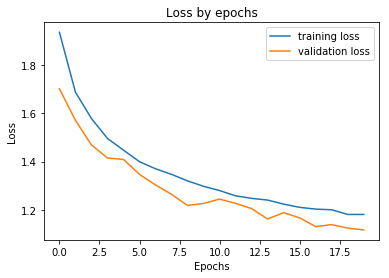

In [7]:
plt.plot(range(epochs), losses_train, label = 'training loss')
plt.plot(range(epochs), losses_valid, label = 'validation loss')
plt.title('Loss by epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

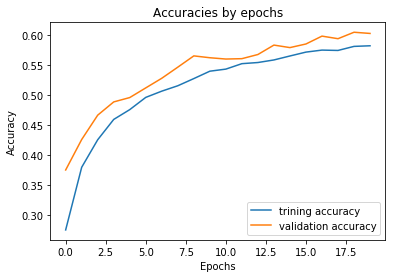

In [8]:
plt.plot(range(epochs), accuracies_train, label = 'trining accuracy')
plt.plot(range(epochs), accuracies_valid, label = 'validation accuracy')
plt.title('Accuracies by epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

**Make a prediction**

Cat


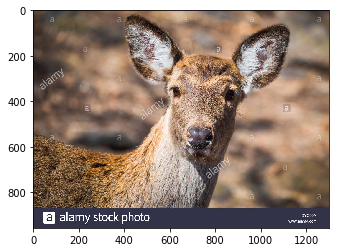

In [9]:
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
resp = req.get(url, stream = True)
img = pil.Image.open(resp.raw)
plt.imshow(img)
predict_transform = tv.transforms.Compose([
  tv.transforms.Resize(32),  
  tv.transforms.CenterCrop(32),
  tv.transforms.ToTensor()  
])
img = predict_transform(img)
with t.no_grad():
  img = img.view(1, 3, 32, 32)
  pred = model.forward(img.cuda())
  val_max, index_max = t.max(pred, 1)
  print(CIFAR_classes[index_max[0]])